In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
scope = ['https://www.googleapis.com/auth/spreadsheets','https://www.googleapis.com/auth/drive.file','https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name("macros-key.json", scope)
client = gspread.authorize(creds)
print(client.openall())

Macros = client.open("Macros Tracker").worksheet("Data(Macros)")
Medidas = client.open("Macros Tracker").worksheet("Medidas")

[<Spreadsheet 'Macros Tracker' id:14U-sVJes0LPbPchyDLNYkI7eK6_jfunmWlG2qMte1_U>]


In [3]:
def norm(x, n=1):
    return n*(x-np.amin(x))/(np.amax(x)-np.amin(x))

def media(x, n):
    
    X=np.zeros(len(x)-n+1)
    
    for i in range(len(x)-n+1):
        X[i] = np.sum(x[i:(i+n)])/n
    return (X)

def media_sem(x, d, s):
    X = np.array([])
    
    D = np.delete(s, 0)
    
    if D[len(D)-1] not in d:
        D = np.delete(D,len(D)-1)
    
    b = np.isin(d, D)
    for i in range(len(b)):
        if b[i]:
            if i < 7:
                X0 = np.sum(x[0:(i+1)])/i
                X = np.append(X, X0)
            else:
                X0 = np.sum(x[(i-6):(i+1)])/7
                X = np.append(X, X0)
        
    
    return D, X

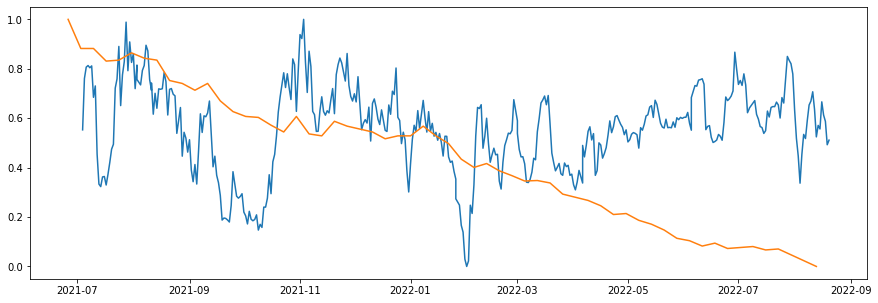

In [4]:
dataV = np.array(Macros.get_all_values())
dataM = np.array(Medidas.get_all_values())

dates = dataV.T[0][1:].astype(np.datetime64 )
dates_ = dataM.T[0][1:].astype(np.datetime64 )
CALS= dataV.T[len(dataV[0])-1][1:].astype(np.float)
peso = dataM.T[1][1:].astype(np.float)
#bf= dataM.T[5][4:].astype(np.float)

n = 7
fig, ax = plt.subplots(figsize=[15, 5])
#ax.plot(dates, norm(CALS))
ax.plot(dates[n-1:], norm(media(CALS,n)))
ax.plot(dates_, norm(peso))
#ax.plot(dates_[n-4:], norm(bf))

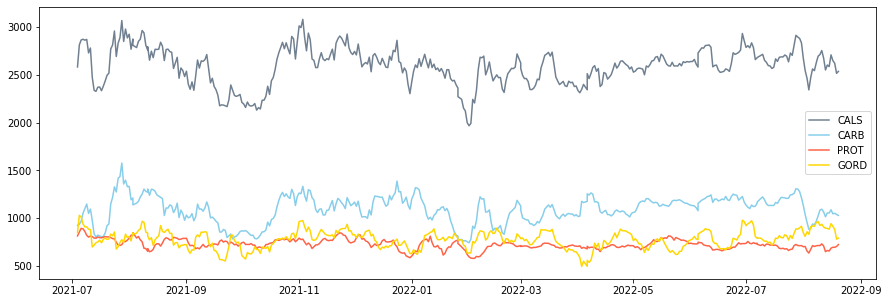

In [5]:
fig, ax = plt.subplots(figsize=[15, 5])
CARB= dataV.T[len(dataV[0])-4][1:].astype(np.float)
PROT= dataV.T[len(dataV[0])-3][1:].astype(np.float)
GORD= dataV.T[len(dataV[0])-2][1:].astype(np.float)

n=7
list_ = [CALS, CARB, PROT, GORD]
list_names = ['CALS', 'CARB', 'PROT', 'GORD']
ax.plot(dates[n-1:], media(CALS  ,n), label="CALS", c= 'slategray')
ax.plot(dates[n-1:], media(CARB*4,n), label="CARB", c= 'skyblue')
ax.plot(dates[n-1:], media(PROT*4,n), label="PROT", c= 'tomato')
ax.plot(dates[n-1:], media(GORD*9,n), label="GORD", c= 'gold')

plt.legend()

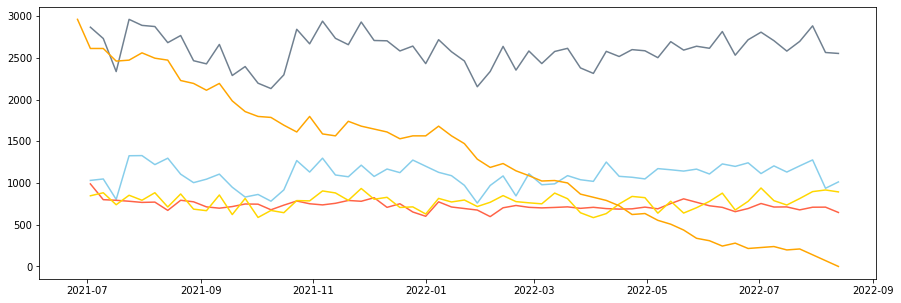

In [6]:
fig, ax = plt.subplots(figsize=[15, 5])

D , K =media_sem(CALS, dates, dates_)
ax.plot(D, K, c= 'slategray', label ="CALS")

D , C =media_sem(CARB, dates, dates_)
ax.plot(D, 4*C, c= 'skyblue', label ="CARB")
D , P =media_sem(PROT, dates, dates_)
ax.plot(D, 4*P, c= 'tomato', label ="PROT")
D , G =media_sem(GORD, dates, dates_)
ax.plot(D, 9*G, c= 'gold', label ="GORD")

ax.plot(dates_, norm(peso, n=np.amax(K)), c='orange', label ="PESO")

-0.3888788995463126 97.28644895360249
-0.33000000000290264 94.38000000020376


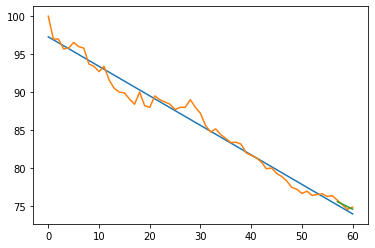

In [7]:
def l(x,a,b):
    return a*x+b

n, m, j = len(dates_), 4, 0
xdata = np.array(range(n))
popt, pcov = curve_fit(l, xdata, peso)
poptM, pcovM = curve_fit(l, xdata[n-m-j:n-j], peso[n-m-j:n-j])
plt.plot(xdata, l(xdata,*popt))
plt.plot(xdata, peso)
plt.plot(xdata[n-m-j:n-j], l(xdata[n-m-j:n-j],*poptM))
print(popt[0],popt[1])

print(poptM[0],poptM[1])

a = poptM[0] 

-0.3879611290521143 97.25977814182697 0.3670588535857034 1.1284638470038721 -0.2828715195978046


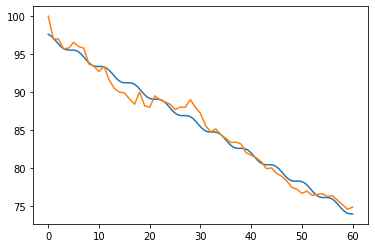

In [8]:
def f(x,a,b,A,w,p):
    return (a*x+b)+A*np.cos(x*w+p)

X=np.linspace(0, n-1, 100)
poptW, pcovW = curve_fit(f, xdata, peso)
print(poptW[0],poptW[1],poptW[2],poptW[3],poptW[4])
plt.plot(X, f(X,*poptW))
plt.plot(xdata, peso)

In [9]:
Cals_sem = media(CALS,28)
Cals_mes = Cals_sem[len(Cals_sem)-1]

GastoMetabolico = Cals_mes + (m*(-a)*7700)/28
print(GastoMetabolico, ",portanto para perder peso se deve comer entre ", GastoMetabolico, " e ", GastoMetabolico*0.8)


2997.232142860335 ,portanto para perder peso se deve comer entre  2997.232142860335  e  2397.785714288268
